# CoViD 19 - Data Viz Lombardia

In [684]:
import os
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn-white')

print("pandas v: {}".format(pd.__version__))

pandas v: 0.25.1


In [685]:
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

# colors
col_green = "#{:02x}{:02x}{:02x}".format(0,158,115)
col_yellow = "#{:02x}{:02x}{:02x}".format(240, 228, 66)
col_blue = "#{:02x}{:02x}{:02x}".format(0, 114, 178)
col_red = "#{:02x}{:02x}{:02x}".format(213, 94, 0)
col_orange = "#{:02x}{:02x}{:02x}".format(230, 159, 0)
col_violet = "#{:02x}{:02x}{:02x}".format(204, 121, 167)
col_skyblue = "#{:02x}{:02x}{:02x}".format(86, 180, 233)

Read data

In [686]:
file_input = []
for f in os.listdir('COVID-19/dati-regioni/'):
    if re.match('dpc-covid19-ita-regioni-2020',f):
        file_input.append(f)


In [687]:
df = pd.read_csv(os.path.join('COVID-19/dati-regioni',file_input[0]))
for i in range(1,len(file_input)):
    df = pd.concat([df, pd.read_csv(os.path.join('COVID-19','dati-regioni',file_input[i]))])

In [688]:
df['data'] = df.data.apply(lambda x : x[:10])
df['data'] = pd.to_datetime(df.data)
df = df.sort_values('data')
df['wday'] = df.data.dt.weekday
df.loc[:,'week'] = df.data.dt.week

In [689]:
df_lom = df[df.denominazione_regione.isin(['Lombardia'])].reset_index(drop=True)
df_lom['deceduti_giornalieri'] = df_lom.deceduti.diff()
df_lom['ter_intensiva_giornalieri'] = df_lom.terapia_intensiva.diff()

Quick overview of Regioni dataset:

In [690]:
print(df.shape)
df.tail(6)

(1134, 21)


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,wday,week
1,2020-04-17,ITA,17,Basilicata,40.639471,15.805148,59,9,68,198,...,-7,1,49,22,337,5710,NaN,NaN,4,16
0,2020-04-17,ITA,13,Abruzzo,42.351222,13.398438,319,43,362,1580,...,92,97,255,246,2443,25436,NaN,NaN,4,16
19,2020-04-17,ITA,2,Valle d'Aosta,45.737503,7.320149,108,9,117,374,...,-27,22,379,123,993,4366,NaN,NaN,4,16
18,2020-04-17,ITA,10,Umbria,43.106758,12.388247,111,31,142,352,...,-42,8,786,57,1337,22818,NaN,NaN,4,16
7,2020-04-17,ITA,12,Lazio,41.892770,12.483667,1332,187,1519,2695,...,70,144,978,332,5524,84755,NaN,NaN,4,16
17,2020-04-17,ITA,4,P.A. Trento,46.068935,11.121231,286,44,330,1660,...,-97,82,1044,342,3376,21921,NaN,NaN,4,16


## Plots

### (1) - Nuovi casi di contagi giornalieri in Lombardia.

/anaconda/envs/py37ds/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:894: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  f = lambda x: func(x, *args, **kwargs)


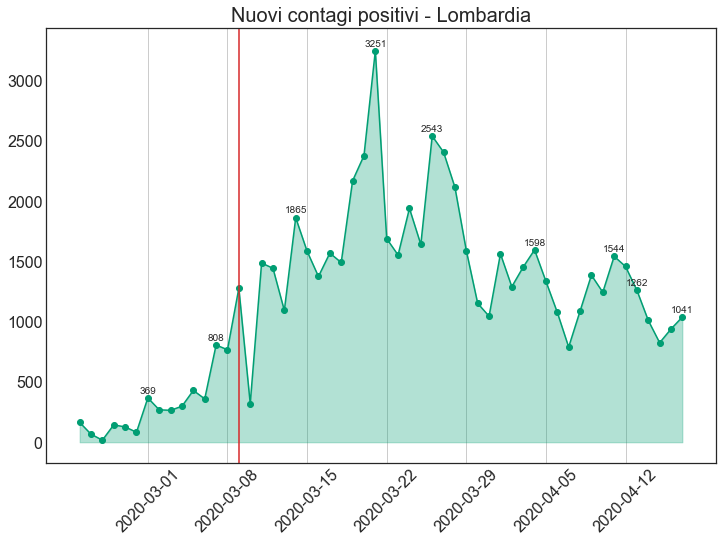

In [691]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rc('axes', axisbelow=True)
gdf = df_lom.groupby(['week']).agg({'nuovi_positivi':[pd.Series.argmax, max]}).reset_index()


plt.plot(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.scatter(df_lom.data, df_lom.nuovi_positivi, color=col_green)
plt.gca().xaxis.grid(color='gray',alpha=0.5)
plt.fill_between(x=df_lom.data, y1=df_lom.nuovi_positivi,color=col_green,alpha=0.3)

plt.gca().set_axisbelow(True)
  
for l in range(len(df_lom.nuovi_positivi)):
    if (l in gdf['nuovi_positivi']['idxmax'].values.tolist() or l == len(df_lom)-1):
        plt.text(x=df_lom.data.values[l],
                 y=df_lom.nuovi_positivi.values[l] +20,
                 s=round(df_lom.nuovi_positivi.values[l],1),
                 size=10,horizontalalignment='center',
                 verticalalignment='bottom'#,alpha=0.8
                )
_ = plt.title('Nuovi contagi positivi - Lombardia')
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45)
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')

### (2) Nuovi contagi confrontati con il resto d'Italia

In [692]:
gdf = df.groupby(['data']).agg({'nuovi_positivi':'sum'}).reset_index().rename(columns={'nuovi_positivi':'nuovi_positivi_ita'})
df_lom = pd.merge(df_lom, gdf, on=['data'])
df_lom['perc_nuovi_positivi'] = df_lom.nuovi_positivi / df_lom.nuovi_positivi_ita
df_lom['nuovi_positivi_resto'] = df_lom.nuovi_positivi_ita - df_lom.nuovi_positivi

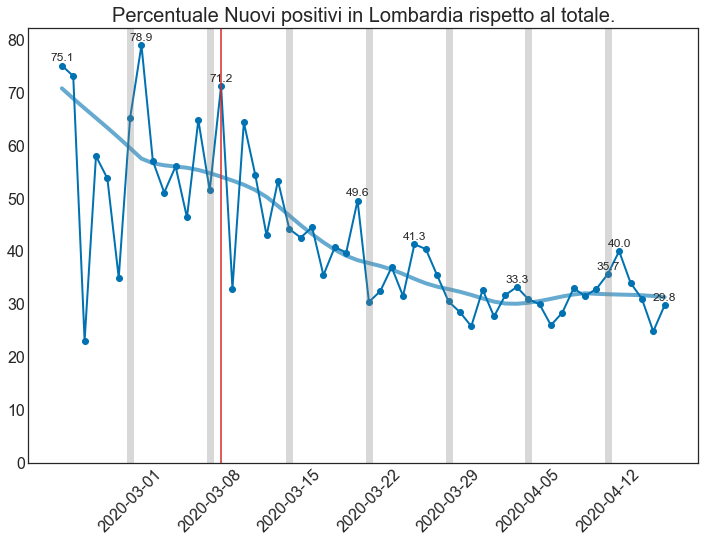

In [693]:
plt.rcParams['figure.figsize'] = 12, 8

smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))), endog=df_lom.perc_nuovi_positivi.values,frac=0.3)[:,1]
gdf = df_lom.groupby(['week']).agg({'perc_nuovi_positivi':[pd.Series.argmax, max]}).reset_index()
col = '#{:02x}{:02x}{:02x}'.format( 0, 113 , 188 )

plt.plot(df_lom.data, df_lom.perc_nuovi_positivi*100,color=col_blue,linewidth=2)
plt.scatter(df_lom.data, df_lom.perc_nuovi_positivi*100,color=col_blue,linewidth=1)
plt.plot(df_lom.data, smooth*100,color=col_blue,alpha=0.6,linewidth=4)
_ = plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45)
_=plt.ylim(0)
for b in df_lom[df_lom.wday.isin([6])].data.values:
    plt.axvline(b,color='gray',linewidth=7,alpha=0.3)
plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')
    
for l in range(len(df_lom.perc_nuovi_positivi)):
    if (l in gdf['perc_nuovi_positivi']['idxmax'].values.tolist() or l == len(df_lom)-1):
        plt.text(x=df_lom.data.values[l],
                 y=df_lom.perc_nuovi_positivi.values[l]*100 +0.5,
                 s=round(df_lom.perc_nuovi_positivi.values[l]*100,1),
                 size=7.5,horizontalalignment='center',
                 verticalalignment='bottom',fontsize=12
                )

_ = plt.title('Percentuale Nuovi positivi in Lombardia rispetto al totale.',size=20)

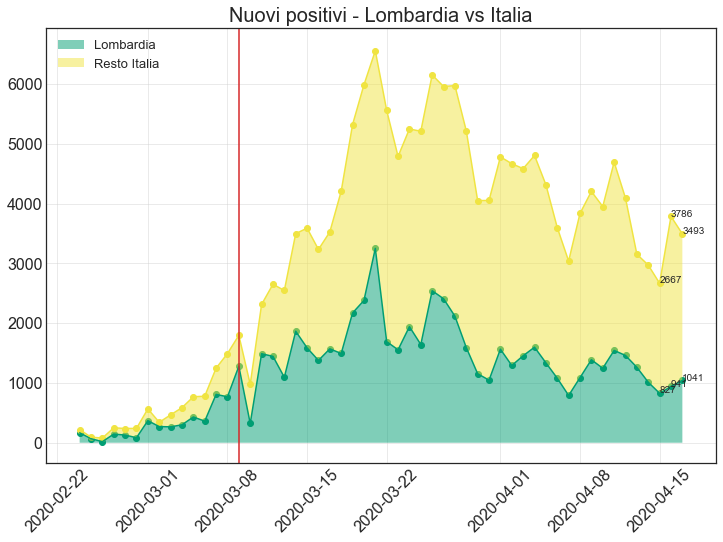

In [694]:
plt.rcParams['figure.figsize'] = 12, 8
plt.plot(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.scatter(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.plot(df_lom.data, df_lom.nuovi_positivi_ita, color=col_yellow)
plt.scatter(df_lom.data, df_lom.nuovi_positivi_ita, color=col_yellow)
plt.stackplot(df_lom.data, [df_lom.nuovi_positivi,df_lom.nuovi_positivi_resto],
              colors=[col_green,col_yellow],alpha=0.5,
              labels=['Lombardia','Resto Italia'])
plt.legend(loc='upper left',fontsize=13)
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)
plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')
plt.title('Nuovi positivi - Lombardia vs Italia',size=20)
_=plt.xticks(rotation=45)
_=plt.yticks(rotation=0)
for i in range(1,4):
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.nuovi_positivi[len(df_lom)-i],s=df_lom.nuovi_positivi[len(df_lom)-i])
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.nuovi_positivi_ita[len(df_lom)-i],s=df_lom.nuovi_positivi_ita[len(df_lom)-i])

In [695]:
i = len(df_lom)-1
print("Change Percentage Lombardia: {}".format(np.round(df_lom.nuovi_positivi.pct_change()[i],2)))
print("Change Percentage Italia: {}".format(np.round(df_lom.nuovi_positivi_ita.pct_change()[i],2)))

Change Percentage Lombardia: 0.11
Change Percentage Italia: -0.08


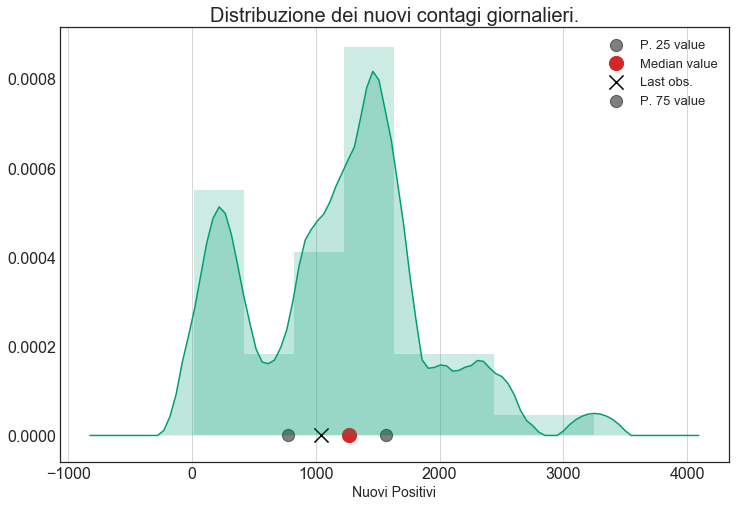

In [696]:
import seaborn as sns
plt.grid(axis='x')
sns.distplot(df_lom.nuovi_positivi,hist=True,color=col_green,
             kde_kws = {'shade': True,'kernel':'epa'},norm_hist=False,hist_kws={'alpha':0.2})
plt.axvline(np.median(df_lom.nuovi_positivi),ymax=0,linewidth=20,color='tab:red')
plt.scatter(np.quantile(df_lom.nuovi_positivi,0.25),0,150,label='P. 25 value',color='black',alpha=0.5)
plt.scatter(np.median(df_lom.nuovi_positivi),0,200,color='tab:red',label='Median value')
plt.scatter(df_lom.nuovi_positivi[len(df_lom)-1],0,200,color='black',marker='x',label='Last obs.')
plt.scatter(np.quantile(df_lom.nuovi_positivi,0.75),0,150,label='P. 75 value',color='black',alpha=0.5)
_=plt.xlabel('Nuovi Positivi')
_=plt.legend(loc='upper right',fontsize=13)
_=plt.title("Distribuzione dei nuovi contagi giornalieri.")

In [697]:
from scipy import stats
pctl_last_obs = np.round(stats.percentileofscore(df_lom.nuovi_positivi,df_lom.nuovi_positivi[i]),2)
print("L'ultima osservazione si trova al {}-mo percentile.".format(pctl_last_obs))

L'ultima osservazione si trova al 37.04-mo percentile.


### (3) Percentage change plot

In [698]:
df_lom['nuovi_positivi_perc_change'] = np.round(df_lom.nuovi_positivi.pct_change(periods=1),1)
df_lom['nuovi_positivi_pc_rol2'] = df_lom.nuovi_positivi.pct_change(1).rolling(2).sum()/2
df_lom['nuovi_positivi_pc_rol3'] = df_lom.nuovi_positivi.pct_change(1).rolling(3).sum()/2

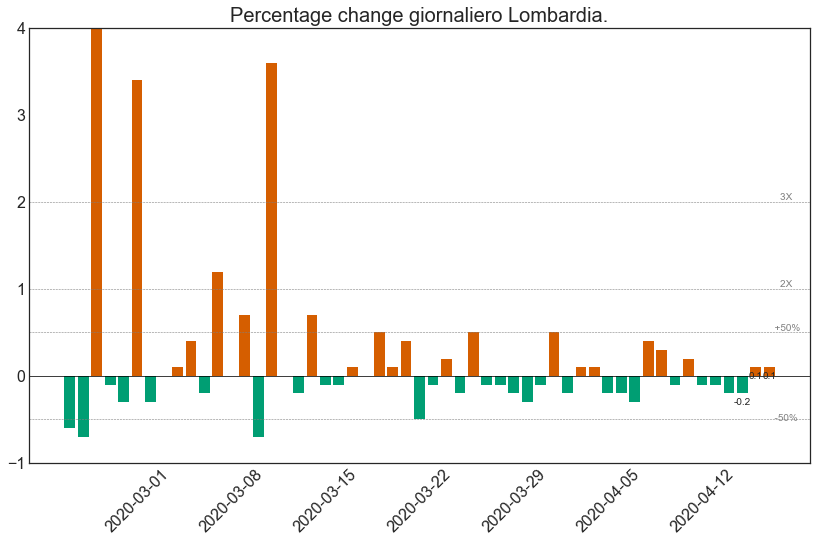

In [699]:
plt.rcParams['figure.figsize'] = 14, 8
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_perc_change']>0].data ,
    height=df_lom[df_lom['nuovi_positivi_perc_change'] > 0].nuovi_positivi_perc_change,color=col_red
)
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_perc_change']<0].data ,
    height=df_lom[df_lom['nuovi_positivi_perc_change'] < 0].nuovi_positivi_perc_change,color=col_green
)
#plt.vlines(
#    x=df_lom.data,ymin=0,
#    ymax=df_lom.nuovi_positivi.pct_change(periods=1)
#)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-1,4)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)

i = len(df_lom)-1
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(-0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.52,s="  +50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="    2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="    3X",color='gray')
_=plt.text(x=df_lom.data[i],y=-0.52,s="  -50%",color='gray')
_=plt.title("Percentage change giornaliero Lombardia.")

for i in range(1,4):
    plt.text(x=df_lom.data[len(df_lom)-i],
             y=df_lom.nuovi_positivi_perc_change[len(df_lom)-i]-0.05,
             s=df_lom.nuovi_positivi_perc_change[len(df_lom)-i],
             verticalalignment='top', horizontalalignment='center')


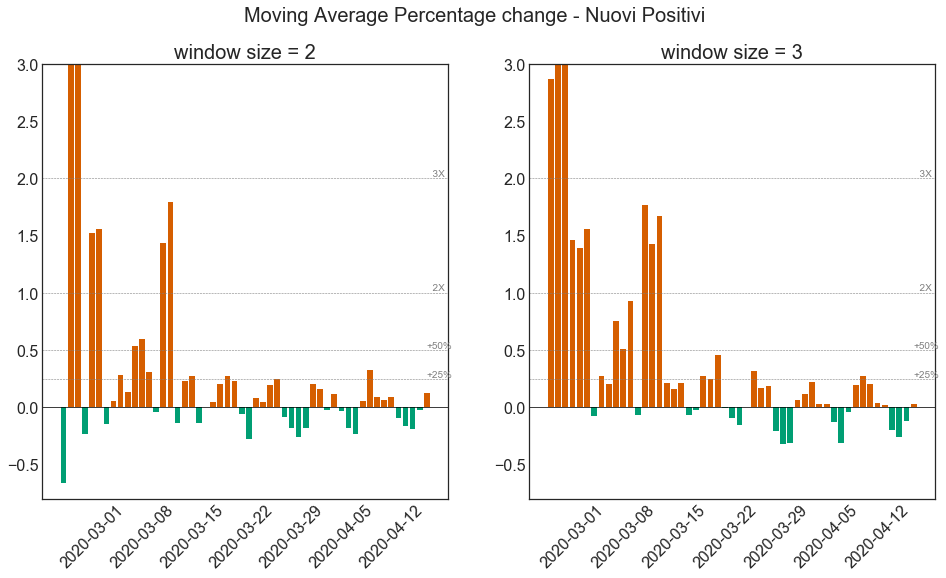

In [700]:
plt.rcParams['figure.figsize'] = 16, 8

#smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))),
#                                 endog=df_lom.nuovi_positivi.pct_change(1).rolling(2).sum()/2,
#                                 frac=0.3)[:,1]
plt.subplot(121)
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_pc_rol2']>0].data,
    height=df_lom[df_lom['nuovi_positivi_pc_rol2']>0].nuovi_positivi_pc_rol2,
    color=col_red
)
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_pc_rol2']<0].data,
    height=df_lom[df_lom['nuovi_positivi_pc_rol2']<0].nuovi_positivi_pc_rol2,
    color=col_green
)
#plt.plot(df_lom.data[2:],smooth,linewidth=5)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-0.8,3)
i = len(df_lom)-1
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('window size = 2')

plt.subplot(122)
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_pc_rol3']>0].data,
    height=df_lom[df_lom['nuovi_positivi_pc_rol3']>0].nuovi_positivi_pc_rol3,
    color=col_red
)
plt.bar(
    x=df_lom[df_lom['nuovi_positivi_pc_rol3']<0].data,
    height=df_lom[df_lom['nuovi_positivi_pc_rol3']<0].nuovi_positivi_pc_rol3,
    color=col_green
)
#plt.plot(df_lom.data[3:],smooth,linewidth=5)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('window size = 3')
_=plt.suptitle("Moving Average Percentage change - Nuovi Positivi", fontsize=20)

### (4) Ricoveri in terapia intensiva

In [701]:
gdf = df.groupby(['data']).agg({'terapia_intensiva':'sum'}).reset_index().rename(columns={'terapia_intensiva':'terapia_intensiva_ita'})
df_lom = pd.merge(df_lom, gdf, on=['data'])
df_lom['terapia_intensiva_resto'] = df_lom.terapia_intensiva_ita - df_lom.terapia_intensiva

In [702]:
perc_change_max = lambda x,m: np.round(( 1-x/m)*100,2)
max_terapia_intensiva_lom = df_lom.terapia_intensiva.max()
id_max_teraapia_intensiva_lom = np.argmax(df_lom.terapia_intensiva.values)
df_lom['perc_change_max_terapia_intensiva']=df_lom.terapia_intensiva.apply(lambda x : -perc_change_max(x,max_terapia_intensiva_lom))
max_terapia_intensiva_ita = df_lom.terapia_intensiva_ita.max()
id_max_teraapia_intensiva_ita = np.argmax(df_lom.terapia_intensiva_ita.values)
df_lom['perc_change_max_terapia_intensiva_ita']=df_lom.terapia_intensiva_ita.apply(lambda x : -perc_change_max(x,max_terapia_intensiva_ita))
max_terapia_intensiva_resto = df_lom.terapia_intensiva_resto.max()
id_max_teraapia_intensiva_resto = np.argmax(df_lom.terapia_intensiva_resto.values)
df_lom['perc_change_max_terapia_intensiva_resto']=df_lom.terapia_intensiva_resto.apply(lambda x : -perc_change_max(x,max_terapia_intensiva_resto))

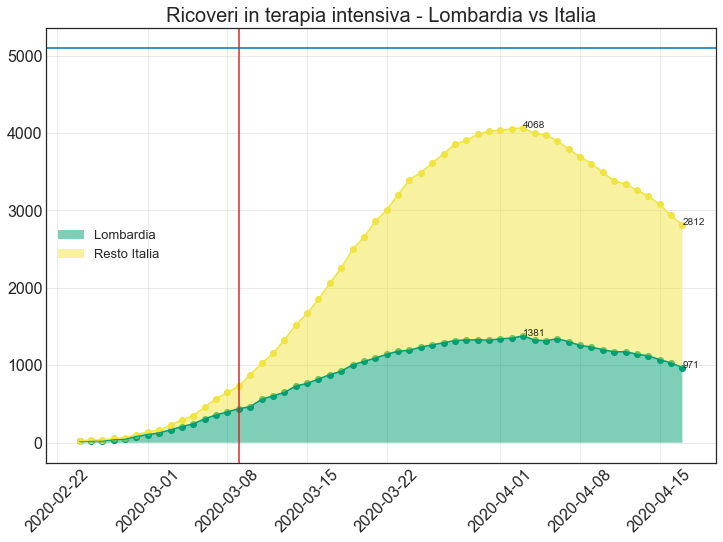

In [703]:
plt.rcParams['figure.figsize'] = 12, 8
plt.plot(df_lom.data, df_lom.terapia_intensiva,color=col_green)
plt.scatter(df_lom.data, df_lom.terapia_intensiva,color=col_green)
plt.plot(df_lom.data, df_lom.terapia_intensiva_ita, color=col_yellow)
plt.scatter(df_lom.data, df_lom.terapia_intensiva_ita, color=col_yellow)
plt.stackplot(df_lom.data, [df_lom.terapia_intensiva,df_lom.terapia_intensiva_resto],
              colors=[col_green,col_yellow],alpha=0.5,
              labels=['Lombardia','Resto Italia'])
plt.legend(loc='center left',fontsize=13)
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)
plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')
plt.title('Ricoveri in terapia intensiva - Lombardia vs Italia',size=20)
_=plt.xticks(rotation=45)
_=plt.yticks(rotation=0)
for i in range(1,2):
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.terapia_intensiva[len(df_lom)-i],s=df_lom.terapia_intensiva[len(df_lom)-i])
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.terapia_intensiva_ita[len(df_lom)-i],s=df_lom.terapia_intensiva_ita[len(df_lom)-i])
    
plt.text(df_lom.data.loc[id_max_teraapia_intensiva_lom],max_terapia_intensiva_lom,max_terapia_intensiva_lom)
_=plt.text(df_lom.data.loc[id_max_teraapia_intensiva_ita],max_terapia_intensiva_ita,max_terapia_intensiva_ita)
_=plt.axhline(5100, color=col_blue)

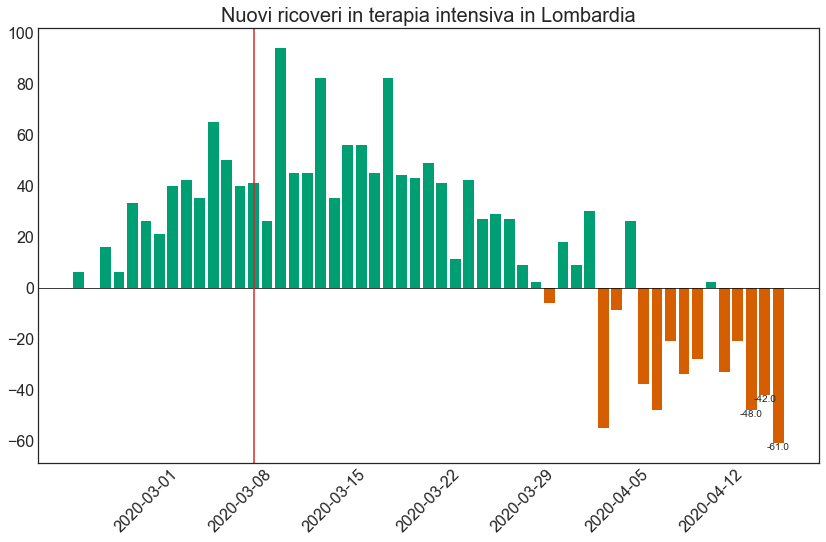

In [704]:
plt.rcParams['figure.figsize'] = 14, 8
plt.bar(
    x=df_lom[df_lom.ter_intensiva_giornalieri>0].data ,
    height=df_lom[df_lom.ter_intensiva_giornalieri> 0].ter_intensiva_giornalieri,color=col_green
)
plt.bar(
    x=df_lom[df_lom.ter_intensiva_giornalieri<0].data ,
    height=df_lom[df_lom.ter_intensiva_giornalieri< 0].ter_intensiva_giornalieri,color=col_red
)

_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)

_ = plt.title('Nuovi ricoveri in terapia intensiva in Lombardia')
for i in range(1,4):
    plt.text(x=df_lom.data[len(df_lom)-i],
             y=df_lom.ter_intensiva_giornalieri[len(df_lom)-i]-0.05,
             s=df_lom.ter_intensiva_giornalieri[len(df_lom)-i],
             verticalalignment='top', horizontalalignment='center')
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')

Numero di giorni con passati dal picco massimo di ricoveri in terapia in intensiva in Italia: 14


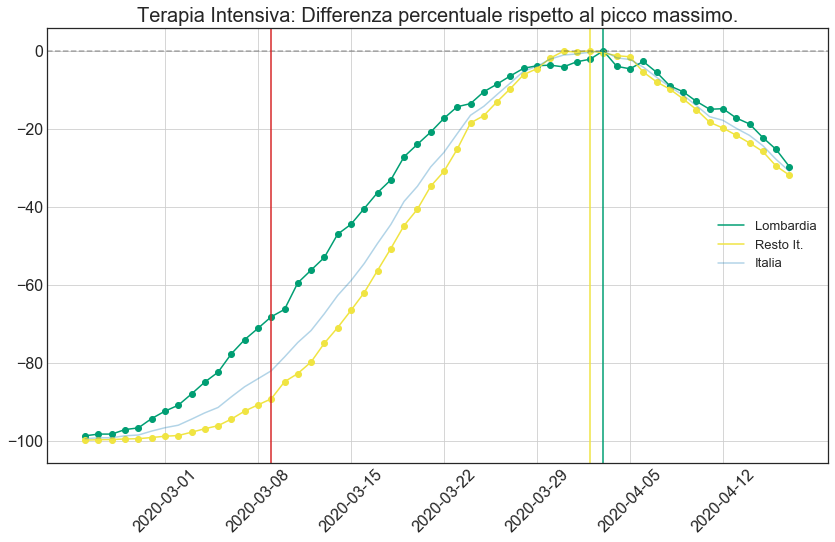

In [705]:
plt.plot(df_lom.data, df_lom.perc_change_max_terapia_intensiva,color=col_green,label='Lombardia')
plt.scatter(df_lom.data, df_lom.perc_change_max_terapia_intensiva,color=col_green)
plt.plot(df_lom.data, df_lom.perc_change_max_terapia_intensiva_resto,color=col_yellow,label='Resto It.')
plt.scatter(df_lom.data, df_lom.perc_change_max_terapia_intensiva_resto,color=col_yellow)
plt.plot(df_lom.data, df_lom.perc_change_max_terapia_intensiva_ita,color=col_blue,label='Italia',alpha=0.3)
_=plt.axvline(df_lom.data.loc[id_max_teraapia_intensiva_lom],color=col_green)
_=plt.axvline(df_lom.data.loc[id_max_teraapia_intensiva_resto],color=col_yellow)
_=plt.axhline(0,color='black',linestyle='--',alpha=0.3)
_=plt.legend(loc='center right',fontsize=13)
_=plt.grid()
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data,rotation=45)
_ = plt.title('Terapia Intensiva: Differenza percentuale rispetto al picco massimo.')
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')

delta_ita = pd.to_datetime(datetime.datetime.now()) - df_lom.data[id_max_teraapia_intensiva_ita]
print("Numero di giorni con passati dal picco massimo di ricoveri in terapia in intensiva in Italia: {}".format(delta_ita.days))

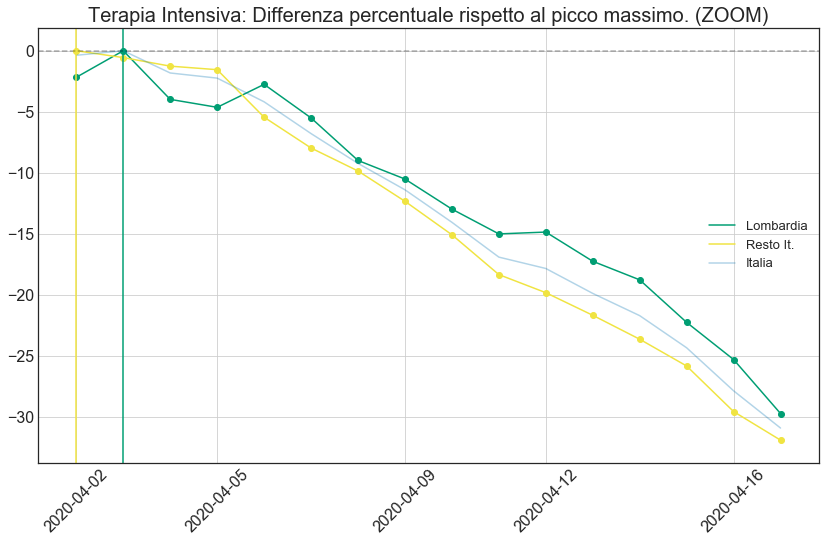

In [706]:
df_tmp = df_lom[df_lom.data >= df_lom.data[id_max_teraapia_intensiva_resto]]
plt.plot(df_tmp.data, df_tmp.perc_change_max_terapia_intensiva,color=col_green,label='Lombardia')
plt.scatter(df_tmp.data, df_tmp.perc_change_max_terapia_intensiva,color=col_green)
plt.plot(df_tmp.data, df_tmp.perc_change_max_terapia_intensiva_resto,color=col_yellow,label='Resto It.')
plt.scatter(df_tmp.data, df_tmp.perc_change_max_terapia_intensiva_resto,color=col_yellow)
plt.plot(df_tmp.data, df_tmp.perc_change_max_terapia_intensiva_ita,color=col_blue,label='Italia',alpha=0.3)
_=plt.axvline(df_tmp.data.loc[id_max_teraapia_intensiva_lom],color=col_green)
_=plt.axvline(df_tmp.data.loc[id_max_teraapia_intensiva_resto],color=col_yellow)
_=plt.axhline(0,color='black',linestyle='--',alpha=0.3)
_=plt.legend(loc='center right',fontsize=13)
_=plt.grid()
_=plt.xticks(df_tmp[df_tmp.wday.isin([3,6])].data,rotation=45)
_ = plt.title('Terapia Intensiva: Differenza percentuale rispetto al picco massimo. (ZOOM)')

### (5) Decessi in Lombardia

In [707]:
tot_decessi_ita = df[df.data == np.max(df.data)].deceduti.sum()
tot_decessi_lom = df_lom[df_lom.data == np.max(df.data)].deceduti.sum()
print("Numero di decessi per CoViD 19 in Italia: {}".format(tot_decessi_ita))
print("Numero di decessi per CoViD 19 in Lombardia: {} ({}%)".format(tot_decessi_lom,
                                                                    np.round(tot_decessi_lom/tot_decessi_ita*100),2))

Numero di decessi per CoViD 19 in Italia: 22745
Numero di decessi per CoViD 19 in Lombardia: 11851 (52.0%)


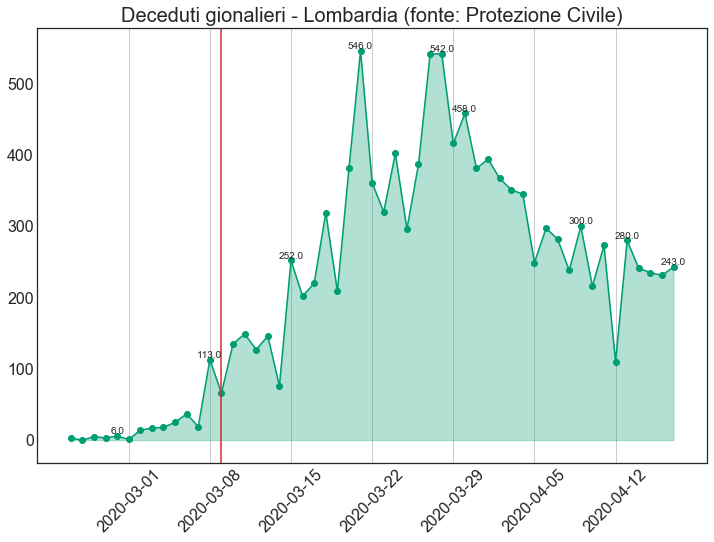

In [708]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rc('axes', axisbelow=True)
gdf = df_lom.groupby(['week']).agg({'deceduti_giornalieri':[pd.Series.argmax, max]}).reset_index()


plt.plot(df_lom.data, df_lom.deceduti_giornalieri,color=col_green)
plt.scatter(df_lom.data, df_lom.deceduti_giornalieri, color=col_green)
plt.gca().xaxis.grid(color='gray',alpha=0.5)
plt.fill_between(x=df_lom.data, y1=df_lom.deceduti_giornalieri,color=col_green,alpha=0.3)

plt.gca().set_axisbelow(True)
  
for l in range(len(df_lom.deceduti_giornalieri)):
    if (l in gdf['deceduti_giornalieri']['idxmax'].values.tolist() or l == len(df_lom)-1):
        plt.text(x=df_lom.data.values[l],
                 y=df_lom.deceduti_giornalieri.values[l] +0,
                 s=round(df_lom.deceduti_giornalieri.values[l],1),
                 size=10,horizontalalignment='center',
                 verticalalignment='bottom'#,alpha=0.8
                )
_ = plt.title("Deceduti gionalieri - Lombardia (fonte: Protezione Civile)")
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45)
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')

Dati su decessi ISTAT

In [709]:
df_decessi = pd.read_csv('comune-giorno/comune_giorno.csv',encoding='latin',na_values=[9999])
get_month = lambda x : str(x)[0] if len(str(x)) == 3 else str(x)[:2]
get_age_cat = lambda x : '<50' if x<=10 else '>=50'
df_decessi['month'] = df_decessi.GE.apply(lambda x :get_month(x))
df_decessi['age_cat'] = df_decessi.CL_ETA.apply(lambda x :get_age_cat(x))

df_ist_lom = df_decessi[df_decessi['NOME_REGIONE'] == 'Lombardia']

In [710]:
n_decessi_lom_19 = n_decessi_lom_19 = df_ist_lom.dropna().TOTALE_19.sum()
n_decessi_lom_20 = df_ist_lom.dropna().TOTALE_20.sum()


print("Numero decessi al 30/03/2019: {}".format(n_decessi_lom_19))
print("Numero decessi al 30/03/2020: {}".format(n_decessi_lom_20))
print("Delta: {}".format(n_decessi_lom_20-n_decessi_lom_19))
print("Percentage change: {} %".format(np.round((n_decessi_lom_20-n_decessi_lom_19)/n_decessi_lom_19*100,2)))

#len(set(df_ist_lom.NOME_COMUNE.unique()) - set(df_ist_lom.dropna().NOME_COMUNE.unique()))

Numero decessi al 30/03/2019: 18454
Numero decessi al 30/03/2020: 26749.0
Delta: 8295.0
Percentage change: 44.95 %


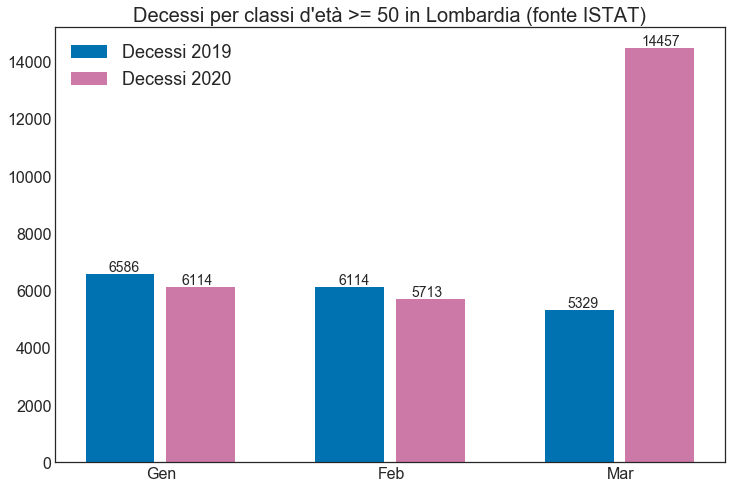

In [711]:
gr_month_age= df_ist_lom.dropna().groupby(['month','age_cat']).agg({'TOTALE_19':'sum', 'TOTALE_20':'sum'}).reset_index()
gr_month_age_lt50 = gr_month_age[gr_month_age.age_cat.isin(['<50'])].reset_index(drop=True)
gr_month_age_gt50 = gr_month_age[gr_month_age.age_cat.isin(['>=50'])].reset_index(drop=True)

plt.bar(x=range(len(gr_month_age_gt50)), height=gr_month_age_gt50.TOTALE_19,width=0.3,color=col_blue,label='Decessi 2019')
plt.bar(x=np.arange(len(gr_month_age_gt50)) + 0.35, height=gr_month_age_gt50.TOTALE_20,width=0.3,color=col_violet,label='Decessi 2020')
plt.xticks(np.arange(len(gr_month_age_gt50))+0.18,['Gen','Feb','Mar'])
plt.legend(loc='upper left',fontsize=18)
for t in np.arange(len(gr_month_age_gt50)):
    plt.text(t-0.05,gr_month_age_gt50.TOTALE_19[t]+100,gr_month_age_gt50.TOTALE_19[t],fontsize=14)
    plt.text(t+0.27,gr_month_age_gt50.TOTALE_20[t]+100,gr_month_age_gt50.TOTALE_20[t].astype(int),fontsize=14)
    
_=plt.title("Decessi per classi d'età >= 50 in Lombardia (fonte ISTAT)")

In [712]:
get_data = lambda x,y : datetime.datetime.strptime(str(x)[0].zfill(2)+str(x)[1:]+y, '%m%d%Y') if len(str(x)) == 3 else datetime.datetime.strptime(str(x)[0]+str(x)[1:]+y)

gr_day_2020 = df_ist_lom.dropna().groupby(['GE']).agg({'TOTALE_20':'sum'}).reset_index()
gr_day_2020['data'] = gr_day_2020.GE.apply(lambda x: get_data(x,'2020'))

df_lom = pd.merge(df_lom, gr_day_2020.drop(columns=['GE']), on=['data'], how='left').rename(columns={'TOTALE_20':'decessi_tot_ISTAT'})

In [713]:
stima_decessi_senza_covid_s = np.round(5000/30,0) 
stima_decessi_senza_covid_m = np.round(5250/30,0) 
stima_decessi_senza_covid_h = np.round(5500/30,0) 

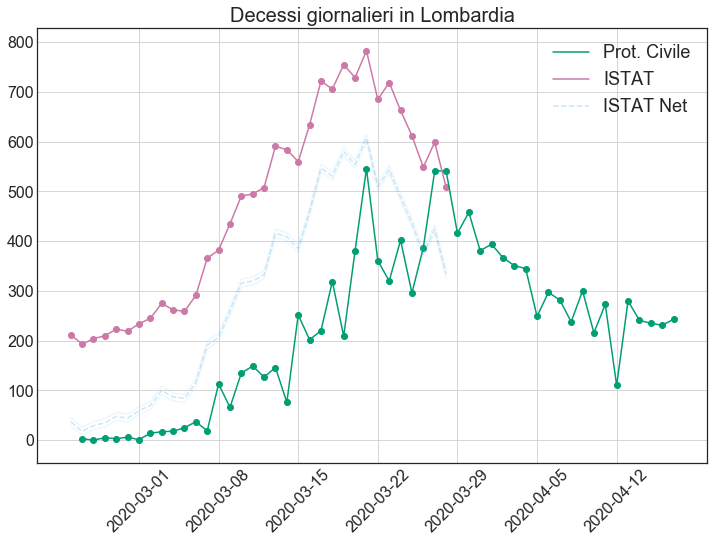

In [715]:
plt.plot(df_lom.data, df_lom.deceduti_giornalieri, label='Prot. Civile', color=col_green)
plt.plot(df_lom.data, df_lom.decessi_tot_ISTAT,label='ISTAT',color=col_violet)
plt.plot(df_lom.data, df_lom.decessi_tot_ISTAT-stima_decessi_senza_covid_h,color=col_skyblue,alpha=0.1)
plt.plot(df_lom.data, df_lom.decessi_tot_ISTAT-stima_decessi_senza_covid_m,color=col_skyblue,alpha=0.3,linestyle='--',label='ISTAT Net')
plt.plot(df_lom.data, df_lom.decessi_tot_ISTAT-stima_decessi_senza_covid_s,color=col_skyblue,alpha=0.1)
plt.scatter(df_lom.data, df_lom.deceduti_giornalieri, color=col_green)
plt.scatter(df_lom.data, df_lom.decessi_tot_ISTAT, color=col_violet)
plt.grid()
_=plt.legend(fontsize=18)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data,rotation=45)
_=plt.title("Decessi giornalieri in Lombardia")

In [716]:
df_lom['decessi_istat_net'] = df_lom.decessi_tot_ISTAT-stima_decessi_senza_covid_m
df_lom['delta_decessi_prciv_istat'] = (df_lom['decessi_istat_net'] - df_lom['deceduti_giornalieri'])
df_lom['delta_perc_decessi_prciv_istat'] = (df_lom['decessi_istat_net'] - df_lom['deceduti_giornalieri']) / df_lom['deceduti_giornalieri'] *100

Mediana differenza percentuale tra ISTAT Net e Prot. Civ. : 162.2 %


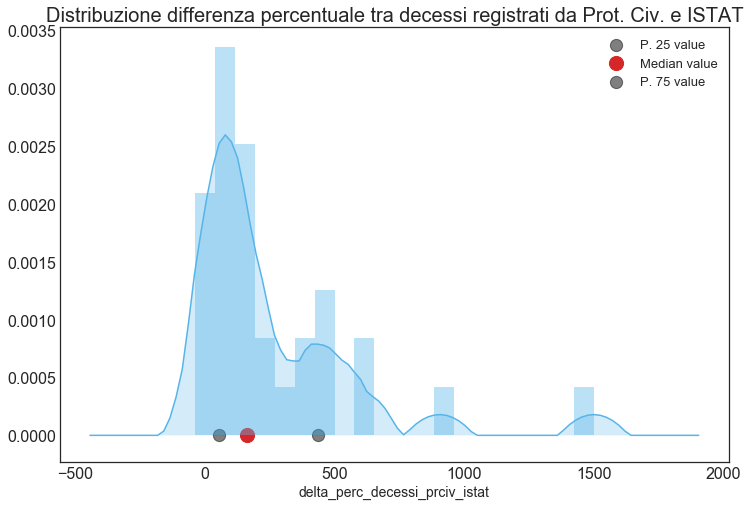

In [717]:
print("Mediana differenza percentuale tra ISTAT Net e Prot. Civ. : {0:.1f} %"
      .format(np.median(df_lom.delta_perc_decessi_prciv_istat.dropna())))
_=sns.distplot(a=df_lom.delta_perc_decessi_prciv_istat[df_lom.delta_perc_decessi_prciv_istat < 2000],
             kde_kws={'shade': True,'kernel':'epa'},color=col_skyblue,bins=20)
plt.scatter(np.quantile(df_lom.delta_perc_decessi_prciv_istat.dropna(),0.25),0,150,label='P. 25 value',color='black',alpha=0.5)
plt.scatter(np.median(df_lom.delta_perc_decessi_prciv_istat.dropna()),0,200,color='tab:red',label='Median value')
_=plt.scatter(np.quantile(df_lom.delta_perc_decessi_prciv_istat.dropna(),0.75),0,150,label='P. 75 value',color='black',alpha=0.5)
_=plt.title("Distribuzione differenza percentuale tra decessi registrati da Prot. Civ. e ISTAT")
_=plt.legend(loc='upper right',fontsize=13)

### (6) Confronto ricoveri terapia intensiva e decessi in Lombardia

In [718]:
df_lom = df_lom.reset_index(drop=True)
perc_change_max = lambda x,m: np.round(( 1-x/m)*100,2)
max_decessi_istat = df_lom.decessi_tot_ISTAT.max()
id_max_decessi_istat = np.argmax(df_lom.decessi_tot_ISTAT.dropna().values)
df_lom['perc_change_max_decessi_istat']=df_lom.decessi_tot_ISTAT.apply(lambda x : -perc_change_max(x,max_decessi_istat))

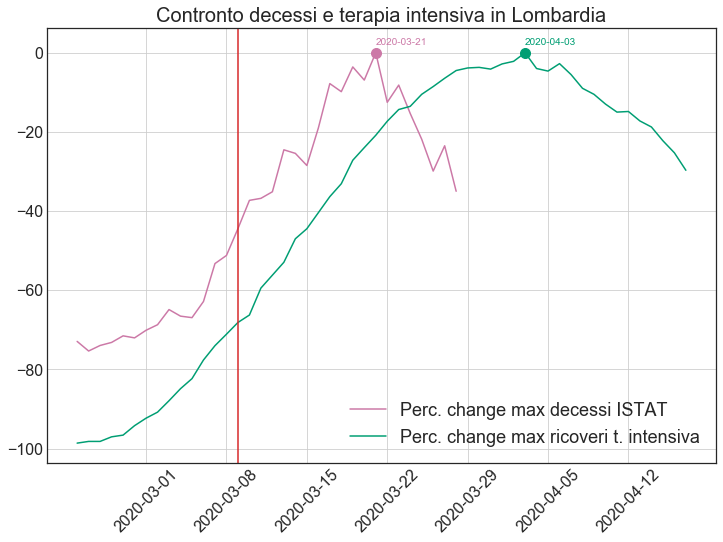

In [719]:
plt.plot(df_lom.data, df_lom.perc_change_max_decessi_istat,color=col_violet,label='Perc. change max decessi ISTAT')
plt.scatter(df_lom.loc[id_max_decessi_istat,'data'],0,100,color=col_violet)
plt.text(df_lom.loc[id_max_decessi_istat,'data'],
         0+2,
         str(df_lom.loc[id_max_decessi_istat,'data'])[:10],color=col_violet)
plt.plot(df_lom.data, df_lom.perc_change_max_terapia_intensiva,color=col_green,label='Perc. change max ricoveri t. intensiva')
plt.scatter(df_lom.loc[id_max_teraapia_intensiva_lom,'data'],0,100,color=col_green)
plt.text(df_lom.loc[id_max_teraapia_intensiva_lom,'data'],
         0+2,
         str(df_lom.loc[id_max_teraapia_intensiva_lom,'data'])[:10],color=col_green)
plt.grid()
_=plt.legend(fontsize=18)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data,rotation=45)
_=plt.title("Contronto decessi e terapia intensiva in Lombardia")
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')